In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.utilities import print_summary
from helper_functions import pred_kernel_parts, gp_predict_fun, hmc_sampling

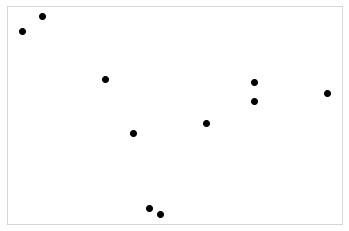

In [2]:
np.random.seed(9102)
X = np.random.uniform(low=0, high=10, size=10)
Y = np.sin(X) + np.random.normal(scale=0.5, size=10)
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)

plt.plot(X, Y, 'ko')
plt.xticks([])
plt.yticks([]);

In [5]:
# from tensorflow_probability import distributions as tfd
# f64 = gpflow.utilities.to_default_float

k = gpflow.kernels.SquaredExponential() # Linear()
m = gpflow.models.GPR(data=(X, Y), kernel=k)
# for p in m.parameters:
    # p.prior = tfd.Gamma(f64(1), f64(1))
opt_logs = gpflow.optimizers.Scipy().minimize(m.training_loss, 
                                              m.trainable_variables, 
                                              options=dict(maxiter=100))
print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.749872  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.740194  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.0379764 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧════════════

In [6]:
m

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.749872
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.740194
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0379764


In [13]:
def calc_bhattacharyya_dist(model1, model2, X):
    """
    Calculate the Bhattacharyya distance between two resulting MVNormal distributions.
    """
    
    # Calculate means and variances
    mu1, var1 = model1.predict_f(X)
    mu2, var2 = model2.predict_f(X)
    
    # Also calculate covariance matrices
    # Pull kernel covariance matrices
    cov1 = model1.kernel.K(X)
    cov2 = model2.kernel.K(X)
    
    # Then add likelihood noise if necessary
    if model1.name == 'gpr' and model2.name == 'gpr':
        cov1 += tf.linalg.diag(tf.repeat(model1.likelihood.variance, X.shape[0]))
        cov2 += tf.linalg.diag(tf.repeat(model2.likelihood.variance, X.shape[0]))
    
    # Calculate average sigma
    cov_all = (cov1 + cov2)/2.
    # After that calculate closed form of Bhattacharyya distance
    dist_b = ((1/8.) * tf.transpose(mu1 - mu2)@tf.linalg.inv(cov_all)@(mu1 - mu2) + 
              0.5*np.log(tf.linalg.det(cov_all)/np.sqrt(tf.linalg.det(cov1)*tf.linalg.det(cov2))))
    return dist_b.numpy()

In [14]:
m2 = gpflow.models.GPR(data=(X, Y), kernel=gpflow.kernels.SquaredExponential())

calc_bhattacharyya_dist(m, m2, X)

array([[1.54930711]])

/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


([], [])

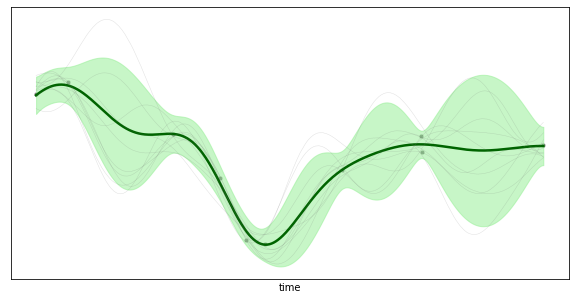

In [4]:
gp_predict_fun(m, 0, 0, col_names=['time'])
plt.xticks([])
plt.yticks([])

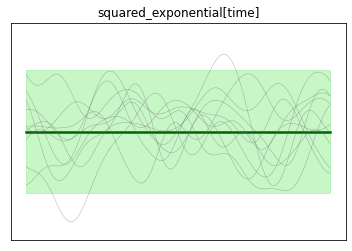

In [5]:
xx = np.linspace(0, 10, 100).reshape(100, 1)  # test points must be of shape (N, D)

# sample from prior
np.random.seed(9102)
mean = m.mean_function(xx).numpy().flatten()
var = m.kernel.K_diag(xx)
samples = np.random.multivariate_normal(
    mean=m.mean_function(xx).numpy().flatten(), 
    cov=m.kernel(xx),
    size=10)

# ## predict mean and variance of latent GP at test points
# mean, var = m.predict_f(xx)

# ## generate 10 samples from posterior
# tf.random.set_seed(9102)  # for reproducibility
# samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
# plt.figure(figsize=(12, 6))
# plt.plot(X, Y, "kx", mew=2)
plt.plot(xx, mean, "darkgreen", lw=2.5)
plt.fill_between(
    xx[:, 0],
     - 1.96 * np.sqrt(var),
     + 1.96 * np.sqrt(var),
    color="lightgreen",
    alpha=0.5,
)

plt.plot(xx, samples.T, "dimgray", linewidth=0.5, alpha=0.5)
plt.ylim(-3, 3)
plt.title('squared_exponential[time]')
plt.xticks([])
plt.yticks([]);

In [20]:
for i,k in enumerate(range(2, 6)):
    print(i%3)

0
1
2
0


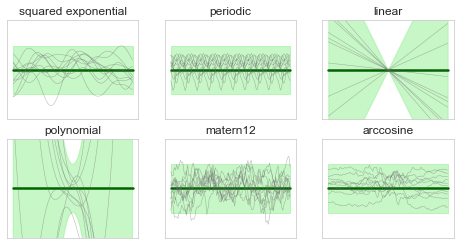

In [34]:
# k = gpflow.kernels.SquaredExponential() # Linear()
# m = gpflow.models.GPR(data=(X, Y), kernel=k)

np.random.seed(9102)
X = np.random.uniform(low=-3, high=3, size=10)
Y = np.sin(X) + np.random.normal(scale=0.1, size=10)
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)

xx = np.linspace(-5, 5, 100).reshape(100, 1)  # test points must be of shape (N, D)

# sample from prior
np.random.seed(9102)
mean = m.mean_function(xx).numpy().flatten()
var = m.kernel.K_diag(xx)
samples = np.random.multivariate_normal(
    mean=m.mean_function(xx).numpy().flatten(),
    cov=m.kernel(xx),
    size=10)

k_list = [gpflow.kernels.SquaredExponential(),
          gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential()),
          gpflow.kernels.Linear(),
          gpflow.kernels.Polynomial(),
          gpflow.kernels.Matern12(),
          gpflow.kernels.ArcCosine()]
k_names = ['squared exponential',
           'periodic',
           'linear',
           'polynomial',
           'matern12',
           'arccosine']

## plot
# plt.figure(figsize=(12, 6))
fig, axs = plt.subplots(2, 3, figsize=(8,4))

for i, k in enumerate(k_list):

    j = 0 if i < 3 else 1

    m = gpflow.models.GPR(data=(X, Y), kernel=k)

    # sample from prior
    np.random.seed(9102)
    mean = m.mean_function(xx).numpy().flatten()
    var = m.kernel.K_diag(xx)
    samples = np.random.multivariate_normal(
        mean=m.mean_function(xx).numpy().flatten(),
        cov=m.kernel(xx),
        size=10)

    axs[j, i%3].plot(xx, mean, "darkgreen", lw=2.5)
    axs[j, i%3].fill_between(
        xx[:, 0],
        - 1.96 * np.sqrt(var),
        + 1.96 * np.sqrt(var),
        color="lightgreen",
        alpha=0.5,
    )

    axs[j, i%3].plot(xx, samples.T, "dimgray", linewidth=0.5, alpha=0.5)
    # axs[j, i%3].set_ylim(-4, 4)
    axs[j, i%3].set_title(k_names[i])
    axs[j, i%3].set_xticks([])
    axs[j, i%3].set_yticks([])

# fig.savefig('../figures/prior_examples.png')

In [6]:
opt_logs = gpflow.optimizers.Scipy().minimize(m.training_loss,
                                              m.trainable_variables, 
                                              options=dict(maxiter=100))
print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.749872  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.740194  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.0379764 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧════════════

In [7]:
# SE = -9.91
# M12 = -10.68
# Per = -12.242
m.log_marginal_likelihood()

<tf.Tensor: shape=(), dtype=float64, numpy=-9.914289155637018>

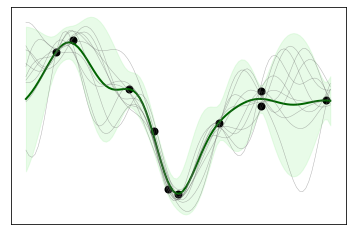

In [8]:
# Prediction
## generate test points for prediction
xx = np.linspace(0, 10, 100).reshape(100, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
#plt.figure(figsize=(12, 6))
plt.plot(X, Y, "ko", mew=2)
plt.plot(xx, mean, "darkgreen", lw=2)
plt.fill_between(
    xx[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="lightgreen",
    alpha=0.2,
)

plt.plot(xx, samples[:, :, 0].numpy().T, "dimgray", linewidth=0.5, alpha=0.5)
plt.xticks([])
plt.yticks([]);

/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


([], [])

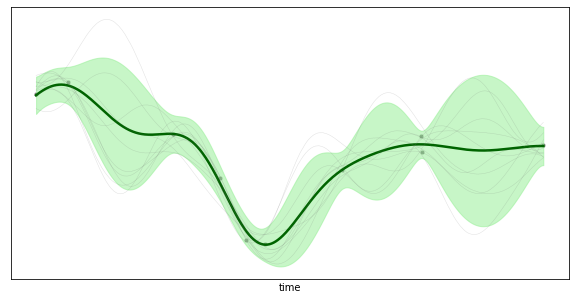

In [9]:
gp_predict_fun(m, 0, 0, col_names=['time'])
plt.xticks([])
plt.yticks([])

Text(0.5, 0, '')

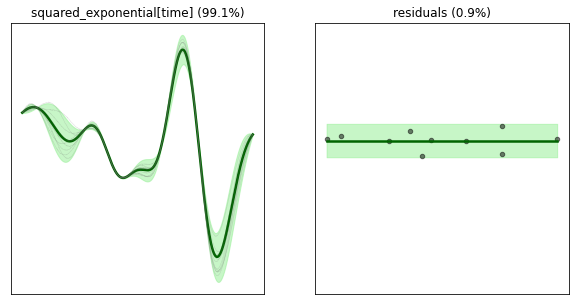

In [10]:
fig, ax = pred_kernel_parts(m, 'squared_exponential[0]', 0, 0, col_names=['time'])
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[0].set_xlabel('')
ax[1].set_xlabel('')

In [ ]:
%%time
hmc_out = hmc_sampling(m, samples=500)

CPU times: user 26min 14s, sys: 5.09 s, total: 26min 19s
Wall time: 26min 16s


In [ ]:
m

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.749872
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.740194
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0379764


In [ ]:
m.trainable_parameters

(<Parameter: dtype=float64, shape=[], fn="softplus", numpy=0.7401937019824303>,
 <Parameter: dtype=float64, shape=[], fn="softplus", numpy=0.7498722077802528>,
 <Parameter: dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=0.03797644835353956>)

In [ ]:
post_samps = {'variance': hmc_out['samples'][0].numpy(),
              'lengthscales': hmc_out['samples'][1].numpy(),
              'like_variance': hmc_out['samples'][2].numpy()}

In [ ]:
m.trainable_parameters[0].numpy()

array(0.7401937)

Text(0.5, 1.0, 'Likelihood variance')

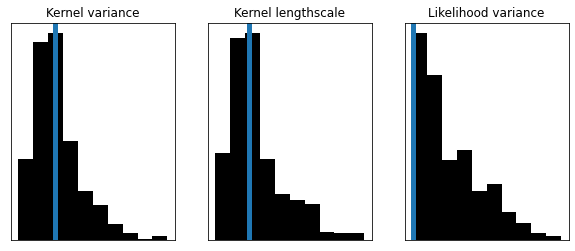

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10,4))
axs[0].hist(post_samps['variance'], color='black');
axs[0].axvline(m.trainable_parameters[0].numpy(), lw=5)
axs[1].hist(post_samps['lengthscales'], color='black');
axs[1].axvline(m.trainable_parameters[1].numpy(), lw=5)
axs[2].hist(post_samps['like_variance'], color='black');
axs[2].axvline(m.trainable_parameters[2].numpy(), lw=5)
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])
axs[1].set_xticklabels([])
axs[1].set_yticklabels([])
axs[2].set_xticklabels([])
axs[2].set_yticklabels([])
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')
axs[0].set_title('Kernel variance')
axs[1].set_title('Kernel lengthscale')
axs[2].set_title('Likelihood variance')

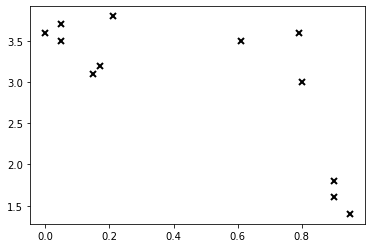

In [ ]:
# data = np.genfromtxt("data/regression_1D.csv", delimiter=",")
# X = data[:, 0].reshape(-1, 1)
# Y = data[:, 1].reshape(-1, 1)

X = np.array([0, 0.05, 0.05, 0.15, 0.17, 0.21, 0.61, 0.79, 0.8, 0.9, 0.9, 0.95]).reshape(-1,1)
Y = np.array([3.6, 3.7, 3.5, 3.1, 3.2, 3.8, 3.5, 3.6, 3.0, 1.8, 1.6, 1.4]).reshape(-1,1)



plt.plot(X, Y, "kx", mew=2);

In [ ]:
k = gpflow.kernels.Matern52()
print_summary(k)

╒═══════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                  │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═══════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Matern52.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├───────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Matern52.lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
╘═══════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════╛


In [ ]:
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │       1 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

In [ ]:
opt_logs = gpflow.optimizers.Scipy().minimize(m.training_loss, 
                                              m.trainable_variables, 
                                              options=dict(maxiter=100))
print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 7.76607   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.492535  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.0969323 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧════════════

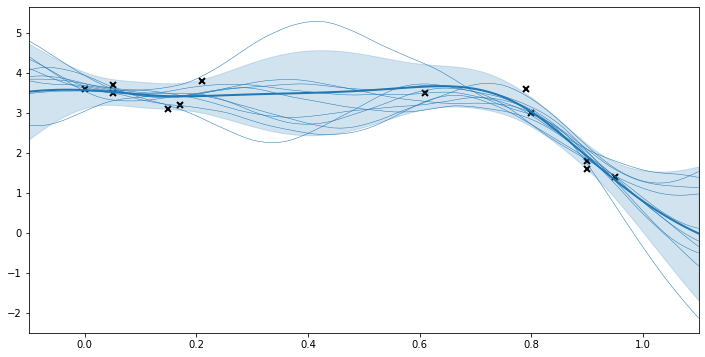

In [ ]:
# Prediction
## generate test points for prediction
xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
plt.figure(figsize=(12, 6))
plt.plot(X, Y, "kx", mew=2)
plt.plot(xx, mean, "C0", lw=2)
plt.fill_between(
    xx[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)

plt.plot(xx, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
_ = plt.xlim(-0.1, 1.1)



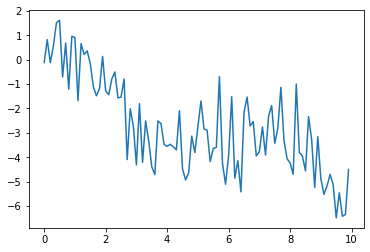

In [224]:
n = 100
x_test = np.arange(0, 10, 10/n).reshape(-1, 1)
f_test = np.random.multivariate_normal(
    mean = np.zeros(n),
    cov = (gpflow.kernels.Linear(variance=1) + gpflow.kernels.SquaredExponential())(x_test)
)
y_test = (f_test + np.random.normal(scale=1, size=n)).reshape(-1, 1)
plt.plot(x_test, y_test)

In [225]:
m_sim = gpflow.models.GPR(data=(x_test, y_test), 
                          kernel=(gpflow.kernels.Linear() + gpflow.kernels.SquaredExponential()))
opt_logs = gpflow.optimizers.Scipy().minimize(m_sim.training_loss, 
                                              m_sim.trainable_variables, 
                                              options=dict(maxiter=1000))
print_summary(m_sim)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.308082 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.850881 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.kernels[1].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.39033  │


/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


<AxesSubplot:xlabel='time'>

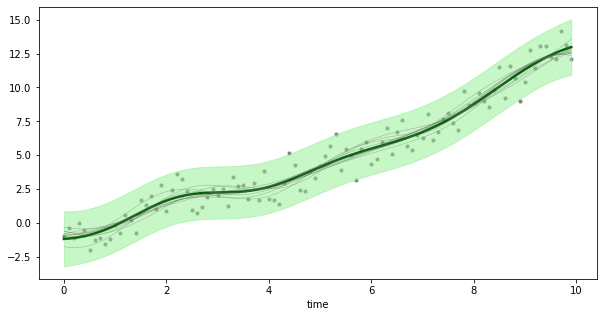

In [193]:
gp_predict_fun(m_sim, 0, 0, col_names=['time'])

In [223]:
x = np.random.normal(size=1000).reshape(-1, 1) + 5
y = 3*x + np.random.normal(scale=2, size=1000).reshape(-1, 1)
m_sim = gpflow.models.GPR(data=(x, y), 
                          kernel=(gpflow.kernels.Linear()))
opt_logs = gpflow.optimizers.Scipy().minimize(m_sim.training_loss, 
                                              m_sim.trainable_variables, 
                                              options=dict(maxiter=1000))
print_summary(m_sim)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 9.00931 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 3.95062 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧═════════╛


/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


<AxesSubplot:xlabel='time'>

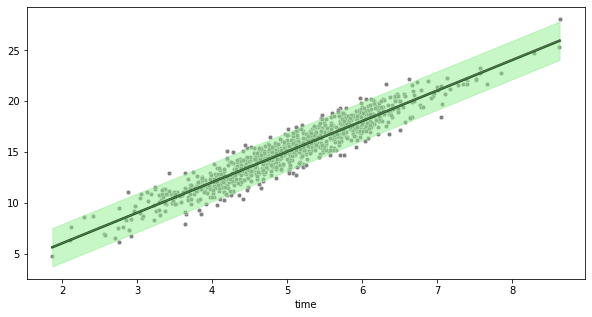

In [222]:
gp_predict_fun(m_sim, 0, 0, col_names=['time'])

In [ ]:
k = gpflow.kernels.SquaredExponential()
# k = gpflow.kernels.Matern12()
# k = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential())
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │       1 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

2022-02-01 13:28:04.515518: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Simple example

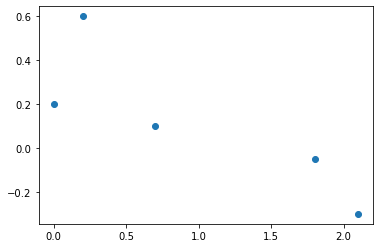

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gpflow
from helper_functions import *

X = np.array([0.0, 0.2, 0.7, 1.8, 2.1]).reshape(-1, 1)
Y = np.array([0.2, 0.6, 0.1, -0.05, -0.3]).reshape(-1, 1)

plt.plot(X, Y, 'o')

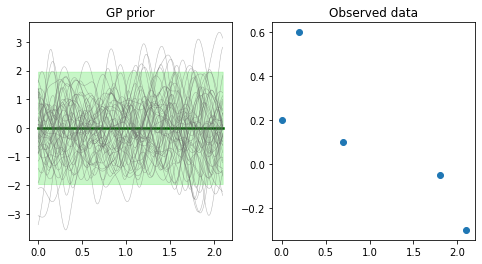

In [88]:
m = gpflow.models.GPR(
    data=(X,Y),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=0.1),
    noise_variance=0.01
)

xx = np.linspace(0, 2.1, 1000).reshape(1000, 1)  # test points must be of shape (N, D)

# sample from prior
np.random.seed(9102)
mean = m.mean_function(xx).numpy().flatten()
var = m.kernel.K_diag(xx)
samples = np.random.multivariate_normal(
    mean=m.mean_function(xx).numpy().flatten(), 
    cov=m.kernel(xx),
    size=50)

# ## predict mean and variance of latent GP at test points
# mean, var = m.predict_f(xx)

# ## generate 10 samples from posterior
# tf.random.set_seed(9102)  # for reproducibility
# samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
# plt.figure(figsize=(12, 6))
# plt.plot(X, Y, "kx", mew=2)

fig, axs = plt.subplots(1, 2, figsize=(8,4))

axs[0].plot(xx, mean, "darkgreen", lw=2.5)
axs[0].fill_between(
    xx[:, 0],
     - 1.96 * np.sqrt(var),
     + 1.96 * np.sqrt(var),
    color="lightgreen",
    alpha=0.5,
)

axs[0].plot(xx, samples.T, "dimgray", linewidth=0.5, alpha=0.5)
axs[0].set_title('GP prior')
# axs[0].ylim(-3, 3)
# plt.title('squared_exponential[time]')
# plt.xticks([])
# plt.yticks([]);

axs[1].plot(X, Y, 'o')
axs[1].set_title('Observed data')

plt.savefig("../figures/prior_and_observed.png", dpi=800)

/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


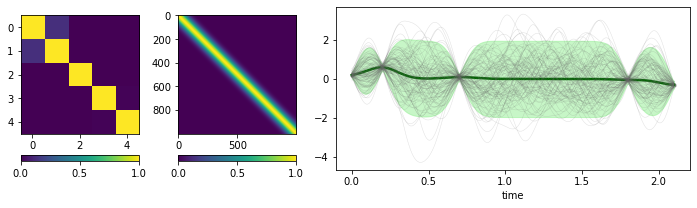

In [89]:
m = gpflow.models.GPR(
    data=(X,Y),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=0.1),
    noise_variance=0.01
)

fig, axs = plt.subplots(1, 3, figsize=(12,3),
                        gridspec_kw={'width_ratios': [1, 1, 3]})
im1 = axs[0].imshow(m.kernel.K(X))
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('bottom', size='5%', pad=0.3)
fig.colorbar(im1, cax=cax, orientation='horizontal')

im2 = axs[1].imshow(m.kernel.K(np.linspace(0, 2.1, 1000).reshape(-1, 1)))
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('bottom', size='5%', pad=0.3)
fig.colorbar(im2, cax=cax, orientation='horizontal')

gp_predict_fun(
    gp=m,
    x_idx=0,
    unit_idx=0,
    col_names=['time'],
    num_funs=100,
    ax=axs[2]
)
plt.savefig("../figures/posterior_naive.png", dpi=800)
plt.show()

/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


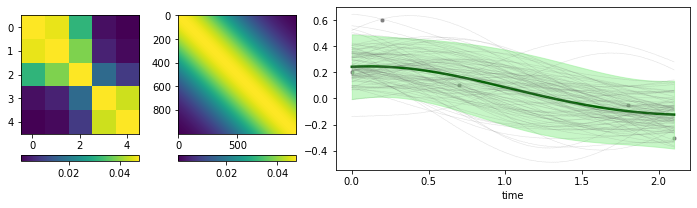

In [90]:
gpflow.optimizers.Scipy().minimize(
    m.training_loss,
    m.trainable_variables,
    #options={'maxiter': 10000}
)

fig, axs = plt.subplots(1, 3, figsize=(12,3),
                        gridspec_kw={'width_ratios': [1, 1, 3]})
im1 = axs[0].imshow(m.kernel.K(X))
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('bottom', size='5%', pad=0.3)
fig.colorbar(im1, cax=cax, orientation='horizontal')

im2 = axs[1].imshow(m.kernel.K(np.linspace(0, 2.1, 1000).reshape(-1, 1)))
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('bottom', size='5%', pad=0.3)
fig.colorbar(im2, cax=cax, orientation='horizontal')

gp_predict_fun(
    gp=m,
    x_idx=0,
    unit_idx=0,
    col_names=['time'],
    num_funs=100,
    ax=axs[2]
)

plt.savefig("../figures/posterior_optimized.png", dpi=800)
plt.show()